In [203]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as st
from IPython.display import display, Markdown
from scipy.optimize import fsolve
from sklearn.linear_model import LinearRegression
import seaborn as sns

from common_plotting import read_data, plot, years, months, yearsFmt, add_thp
from common_analysis import add_dut_and_setting_group, combine_stds_ratio_product, combine_stds_sum
from common_analysis_resistance import analyse_grouped_ohms,  PT385_eq, Trh, Rt, Rs23, interpolate_temp
from common_analysis_dcv import aggregate_absolute_data_by_group

plt.rcParams["figure.figsize"] = (20,10)
orig_max_rows = pd.options.display.max_rows
pd.options.display.max_rows = 100

In [95]:
thp_data, data = read_data(['ks3458a-f5450a-sweep.csv', 'ks3458a-f5450a-sweep-with-1.9.csv', 'ks3458a-d4700-resistance-sweep.csv', 'ks3458a1-f5450a-sweep-with-1.9.csv', 'ks3458a1-d4700-resistance-sweep.csv', 'ks3458a-f5450a-best-resistors-comparison.csv', 'ks3458a-f5450a-best-resistors-comparison2.csv', 'ks3458a-f5450a-best-resistors-comparison-low.csv', 'ks3458a-f5450a-best-resistors-comparison-high.csv', 'w4950-log-resistance-transfer.csv', 'ks3458a1-dcv-log-resistance-transfer.csv', 'ks3458a1-dcv-log-19v-resistance-transfer.csv'])
ks3458a_f5450a_sweep = data['ks3458a-f5450a-sweep.csv']
ks3458a_f5450a_sweep_with_19 = data['ks3458a-f5450a-sweep-with-1.9.csv']
ks3458a_d4700_resistance_sweep = data['ks3458a-d4700-resistance-sweep.csv']
ks3458a1_f5450a_sweep_with_19 = data['ks3458a1-f5450a-sweep-with-1.9.csv']
ks3458a1_d4700_resistance_sweep = data['ks3458a1-d4700-resistance-sweep.csv']
ks3458a_f5450a_best_resistors_comparison = data['ks3458a-f5450a-best-resistors-comparison.csv']
ks3458a_f5450a_best_resistors_comparison2 = data['ks3458a-f5450a-best-resistors-comparison2.csv']
ks3458a_f5450a_best_resistors_comparison3_low = data['ks3458a-f5450a-best-resistors-comparison-low.csv']
ks3458a_f5450a_best_resistors_comparison3_high = data['ks3458a-f5450a-best-resistors-comparison-high.csv']

transfer_w4950 = data['w4950-log-resistance-transfer.csv']
transfer_ks3458a1_dcv = data['ks3458a1-dcv-log-resistance-transfer.csv']
transfer_ks3458a1_dcv_19v = data['ks3458a1-dcv-log-19v-resistance-transfer.csv']

In [10]:
ks3458a_f5450a_sweep_1 = ks3458a_f5450a_sweep[
    (ks3458a_f5450a_sweep.index > pd.Timestamp(2023, 1, 25, 14, 55))
    & (ks3458a_f5450a_sweep.index < pd.Timestamp(2023, 1, 27, 0))
].copy()
ks3458a_f5450a_sweep_2 = ks3458a_f5450a_sweep[
    (ks3458a_f5450a_sweep.index > pd.Timestamp(2023, 1, 27, 0))
    & (ks3458a_f5450a_sweep.index < pd.Timestamp(2023, 2, 16, 0))
].copy()
ks3458a_f5450a_sweep_with_19_1 = ks3458a_f5450a_sweep_with_19[
    (ks3458a_f5450a_sweep_with_19.index > pd.Timestamp(2023, 1, 28, 0))
    & (ks3458a_f5450a_sweep_with_19.index < pd.Timestamp(2023, 1, 30, 0))
].copy()
ks3458a_f5450a_sweep_with_19_2 = ks3458a_f5450a_sweep_with_19[
    (ks3458a_f5450a_sweep_with_19.index > pd.Timestamp(2023, 1, 30, 0))
    & (ks3458a_f5450a_sweep_with_19.index < pd.Timestamp(2023, 2, 3, 0))
].copy()
ks3458a_f5450a_sweep_with_19_3 = ks3458a_f5450a_sweep_with_19[
    (ks3458a_f5450a_sweep_with_19.index > pd.Timestamp(2023, 2, 21, 0))
    & (ks3458a_f5450a_sweep_with_19.index < pd.Timestamp(2023, 2, 23, 0))
].copy()
ks3458a_d4700_resistance_sweep_1 = ks3458a_d4700_resistance_sweep[
    (ks3458a_d4700_resistance_sweep.index > pd.Timestamp(2023, 1, 26, 0))
    & (ks3458a_d4700_resistance_sweep.index < pd.Timestamp(2023, 1, 28, 0))
].copy()
ks3458a_d4700_resistance_sweep_2 = ks3458a_d4700_resistance_sweep[
    (ks3458a_d4700_resistance_sweep.index > pd.Timestamp(2023, 2, 2, 0))
    & (ks3458a_d4700_resistance_sweep.index < pd.Timestamp(2023, 2, 4, 0))
].copy()
ks3458a_d4700_resistance_sweep_3 = ks3458a_d4700_resistance_sweep[
    (ks3458a_d4700_resistance_sweep.index > pd.Timestamp(2023, 2, 21, 0))
    & (ks3458a_d4700_resistance_sweep.index < pd.Timestamp(2023, 2, 22, 0))
].copy()
ks3458a1_f5450a_sweep_with_19_1 = ks3458a1_f5450a_sweep_with_19[
    (ks3458a1_f5450a_sweep_with_19.index > pd.Timestamp(2023, 2, 2, 0))
    & (ks3458a1_f5450a_sweep_with_19.index < pd.Timestamp(2023, 2, 4, 0))
].copy()
ks3458a1_f5450a_sweep_with_19_2 = ks3458a1_f5450a_sweep_with_19[
    (ks3458a1_f5450a_sweep_with_19.index > pd.Timestamp(2023, 2, 21, 0))
    & (ks3458a1_f5450a_sweep_with_19.index < pd.Timestamp(2023, 2, 22, 0))
].copy()
ks3458a1_d4700_resistance_sweep_1 = ks3458a1_d4700_resistance_sweep[
    (ks3458a1_d4700_resistance_sweep.index > pd.Timestamp(2023, 2, 1, 0))
    & (ks3458a1_d4700_resistance_sweep.index < pd.Timestamp(2023, 2, 3, 0))
].copy()
ks3458a1_d4700_resistance_sweep_2 = ks3458a1_d4700_resistance_sweep[
    (ks3458a1_d4700_resistance_sweep.index > pd.Timestamp(2023, 2, 21, 0))
    & (ks3458a1_d4700_resistance_sweep.index < pd.Timestamp(2023, 2, 23, 0))
].copy()


def analyse_ohms_sweep(data, meter):
    meter_number = meter.split("_")[1]
    interpolate_temp(data, f"temp_{meter_number}")
    interpolated_data_without_temp_rows = data[data[f"temp_{meter_number}"].isna()]
    group_columns = ["dut", "dut_setting", f"{meter}_range"]
    groups = (
        (
            interpolated_data_without_temp_rows[group_columns].apply(tuple, axis=1)
            != interpolated_data_without_temp_rows[group_columns]
            .shift()
            .apply(tuple, axis=1)
        )
        .cumsum()
        .rename("group")
    )
    grouped_data = interpolated_data_without_temp_rows.join(groups)
    return analyse_grouped_ohms(
        grouped_data,
        meter=meter,
        temperature_columns=[f"temp_{meter_number}_interpolated", "temperature"],
    )


ks3458a_f5450a_sweep_1_summary = analyse_ohms_sweep(ks3458a_f5450a_sweep_1, "ag3458a_2")
ks3458a_f5450a_sweep_2_summary = analyse_ohms_sweep(ks3458a_f5450a_sweep_2, "ag3458a_2")
ks3458a_f5450a_sweep_with_19_summary_1 = analyse_ohms_sweep(ks3458a_f5450a_sweep_with_19_1, "ag3458a_2")
ks3458a_f5450a_sweep_with_19_summary_2 = analyse_ohms_sweep(ks3458a_f5450a_sweep_with_19_2, "ag3458a_2")
ks3458a_f5450a_sweep_with_19_summary_3 = analyse_ohms_sweep(ks3458a_f5450a_sweep_with_19_3, "ag3458a_2")
ks3458a_d4700_resistance_sweep_summary_1 = analyse_ohms_sweep(ks3458a_d4700_resistance_sweep_1, "ag3458a_2")
ks3458a_d4700_resistance_sweep_summary_2 = analyse_ohms_sweep(ks3458a_d4700_resistance_sweep_2, "ag3458a_2")
ks3458a_d4700_resistance_sweep_summary_3 = analyse_ohms_sweep(ks3458a_d4700_resistance_sweep_3, "ag3458a_2")
ks3458a1_f5450a_sweep_with_19_summary_1 = analyse_ohms_sweep(ks3458a1_f5450a_sweep_with_19_1, "ag3458a_1")
ks3458a1_f5450a_sweep_with_19_summary_2 = analyse_ohms_sweep(ks3458a1_f5450a_sweep_with_19_2, "ag3458a_1")
ks3458a1_d4700_resistance_sweep_summary_1 = analyse_ohms_sweep(ks3458a1_d4700_resistance_sweep_1, "ag3458a_1")
ks3458a1_d4700_resistance_sweep_summary_2 = analyse_ohms_sweep(ks3458a1_d4700_resistance_sweep_2, "ag3458a_1")
ks3458a_f5450a_best_resistors_comparison_summary = analyse_ohms_sweep(ks3458a_f5450a_best_resistors_comparison, "ag3458a_2")
ks3458a_f5450a_best_resistors_comparison_summary2 = analyse_ohms_sweep(ks3458a_f5450a_best_resistors_comparison2, "ag3458a_2")
ks3458a_f5450a_best_resistors_comparison_summary3_low = analyse_ohms_sweep(ks3458a_f5450a_best_resistors_comparison3_low, "ag3458a_2")
ks3458a_f5450a_best_resistors_comparison_summary3_high = analyse_ohms_sweep(ks3458a_f5450a_best_resistors_comparison3_high, "ag3458a_2")

# Resistance comparisons using F5450A and 3458A

In [11]:
ks3458a_f5450a_best_resistors_comparison_summary

,dut,dut_setting,count,ohm_mean,ohm_sem,ohm_std,range,temp_2_interpolated_mean,temperature_mean
group,,,,,,,,,
1,Fluke 5450A,10 kOhm,16,10000.368786,0.000404,0.001616,10000.0,NaN,33.191711
2,Fluke 5450A,short,16,0.000084,0.000122,0.000489,10000.0,51.137037,33.077930
3,SR104,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489
4,Measurements International 9331,10 kOhm,16,9999.815113,0.000272,0.001087,10000.0,51.322975,32.879980
5,Guildline 9330 s/n 45809,10 kOhm,16,10000.437514,0.000414,0.001655,10000.0,51.373438,32.828198
6,SR104,10 kOhm,16,9999.992688,0.000356,0.001423,10000.0,51.354054,32.966919
7,Fluke 5450A,10 kOhm,16,10000.375306,0.000498,0.001992,10000.0,51.267568,33.206970
8,Fluke 5450A,1 kOhm,16,1000.066878,0.000193,0.000772,10000.0,51.203378,33.247986
9,Fluke 5450A,1 kOhm,16,1000.066323,0.000030,0.000121,1000.0,51.200000,33.047412


In [12]:
ks3458a_f5450a_best_resistors_comparison_summary2

,dut,dut_setting,count,ohm_mean,ohm_sem,ohm_std,range,temp_2_interpolated_mean,temperature_mean
group,,,,,,,,,
1,Fluke 5450A,short,16,-1.212705e-04,0.000142,0.000570,10000.0,NaN,35.065259
2,Fluke 5450A,10 kOhm,16,1.000036e+04,0.000405,0.001620,10000.0,50.778571,34.947253
3,SR104,10 kOhm,16,9.999981e+03,0.000238,0.000951,10000.0,50.720238,35.109558
4,Fluke 5450A,10 kOhm,16,1.000035e+04,0.000266,0.001062,10000.0,50.640476,35.174939
5,Fluke 5450A,short,16,3.244593e-05,0.000002,0.000006,10.0,50.582653,35.227930
6,Fluke 5450A,1 Ohm,16,9.998285e-01,0.000002,0.000008,10.0,50.550000,35.220508
7,Fluke 742A,1 Ohm,16,1.000045e+00,0.000002,0.000010,10.0,50.517347,35.349585
8,L&N 4210,1 Ohm,16,9.999993e-01,0.000002,0.000007,10.0,50.500000,35.214111
9,Guildline 9330 s/n 51261,1 Ohm,16,9.999961e-01,0.000002,0.000007,10.0,50.500000,35.171521


In [13]:
pd.concat([ks3458a_f5450a_best_resistors_comparison_summary3_low, ks3458a_f5450a_best_resistors_comparison_summary3_high])

,dut,dut_setting,count,ohm_mean,ohm_sem,ohm_std,range,temp_2_interpolated_mean,temperature_mean
group,,,,,,,,,
1,SR104,10 kOhm,16,1.000010e+04,0.000267,0.001069,10000.0,NaN,30.302380
2,Fluke 5450A,10 kOhm,16,1.000049e+04,0.000214,0.000857,10000.0,48.718085,30.479102
3,Fluke 5450A,short,16,-9.306989e-05,0.000231,0.000923,10000.0,48.752128,30.695715
4,Fluke 5450A,10 kOhm,16,1.000049e+04,0.000190,0.000762,10000.0,48.787024,30.816956
5,SR104,10 kOhm,16,1.000010e+04,0.000217,0.000867,10000.0,48.855263,31.830017
6,Fluke 5450A,10 kOhm,16,1.000049e+04,0.000312,0.001247,10000.0,48.900000,31.460474
7,Fluke 5450A,1 kOhm,16,1.000077e+03,0.000172,0.000688,10000.0,48.900000,31.859351
8,Fluke 5450A,1 kOhm,16,1.000076e+03,0.000025,0.000098,1000.0,48.900000,31.729871
9,Fluke 5450A,100 Ohm,16,1.000057e+02,0.000019,0.000076,1000.0,48.900000,31.276953


## Compare 10k resistors

In [173]:
all_comparison_summaries = [ks3458a_f5450a_best_resistors_comparison_summary, ks3458a_f5450a_best_resistors_comparison_summary2, ks3458a_f5450a_best_resistors_comparison_summary3_low, ks3458a_f5450a_best_resistors_comparison_summary3_high]
# for summary in all_comparison_summaries:


all_comparisons_with_best_resistors = pd.concat(all_comparison_summaries)
results_10k = all_comparisons_with_best_resistors[(all_comparisons_with_best_resistors.dut_setting == "10 kOhm") & (all_comparisons_with_best_resistors.range == 10e3)].reset_index()


In [216]:
diff = results_10k.group - results_10k.group.shift()
results_10k['ref_group'] = ((diff > 3) | (diff < 0)).cumsum()
refs_10k = results_10k[results_10k.dut == 'SR104']
refs_per_group = refs_10k.groupby('ref_group').group.idxmin()
results_10k_with_ref_group = results_10k.join(refs_per_group, on='ref_group', rsuffix='_ref')
results_10k_with_ref = pd.merge(results_10k_with_ref_group, refs_10k.reset_index(), how='left', left_on=['group_ref'], right_on=['index'], suffixes=('', '_ref'))
results_10k_with_ref['rel_ohm_mean_ppm'] = (results_10k_with_ref.ohm_mean - results_10k_with_ref.ohm_mean_ref) / results_10k_with_ref.ohm_mean_ref * 1e6
display(results_10k_with_ref)

,group,dut,dut_setting,count,ohm_mean,ohm_sem,ohm_std,range,temp_2_interpolated_mean,temperature_mean,...,dut_setting_ref,count_ref,ohm_mean_ref,ohm_sem_ref,ohm_std_ref,range_ref,temp_2_interpolated_mean_ref,temperature_mean_ref,ref_group_ref,rel_ohm_mean_ppm
0,1,Fluke 5450A,10 kOhm,16,10000.368786,0.000404,0.001616,10000.0,NaN,33.191711,...,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,0,37.756746
1,3,SR104,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,...,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,0,0.000000
2,4,Measurements International 9331,10 kOhm,16,9999.815113,0.000272,0.001087,10000.0,51.322975,32.879980,...,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,0,-17.610609
3,5,Guildline 9330 s/n 45809,10 kOhm,16,10000.437514,0.000414,0.001655,10000.0,51.373438,32.828198,...,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,0,44.629502
4,6,SR104,10 kOhm,16,9999.992688,0.000356,0.001423,10000.0,51.354054,32.966919,...,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,0,0.146856
5,7,Fluke 5450A,10 kOhm,16,10000.375306,0.000498,0.001992,10000.0,51.267568,33.206970,...,10 kOhm,16,9999.991219,0.000337,0.001349,10000.0,51.229630,32.951489,0,38.408746
6,38,Fluke 5450A,10 kOhm,16,10000.369464,0.000346,0.001385,10000.0,51.500000,33.139185,...,10 kOhm,16,9999.988043,0.000438,0.001751,10000.0,51.500000,33.366162,1,38.142208
7,39,SR104,10 kOhm,16,9999.988043,0.000438,0.001751,10000.0,51.500000,33.366162,...,10 kOhm,16,9999.988043,0.000438,0.001751,10000.0,51.500000,33.366162,1,0.000000
8,2,Fluke 5450A,10 kOhm,16,10000.357626,0.000405,0.001620,10000.0,50.778571,34.947253,...,10 kOhm,16,9999.981008,0.000238,0.000951,10000.0,50.720238,35.109558,2,37.661947
9,3,SR104,10 kOhm,16,9999.981008,0.000238,0.000951,10000.0,50.720238,35.109558,...,10 kOhm,16,9999.981008,0.000238,0.000951,10000.0,50.720238,35.109558,2,0.000000


# Resistance transfer using D4700 and voltage ratios

In [82]:
transfer_w4950_cleaned = transfer_w4950[(transfer_w4950.w4950_value < 1e31) & (transfer_w4950.w4950_value > -1e31)].copy()

In [37]:
transfer_ks3458a1_dcv

,dut,dut_setting,ag3458a_1_dcv,temp_1,last_acal_1,last_acal_1_cal72,temperature,pressure,humidity
datetime,,,,,,,,,
2023-11-06 00:25:58.726036,SR104-GL9330-10k-42709-across-SR104,9.5 V,9.499362,NaN,2023-11-06T00:25:11.771396,1.000757,31.438672,991.782455,31.033449
2023-11-06 00:26:02.821692,SR104-GL9330-10k-42709-across-SR104,9.5 V,9.499358,NaN,2023-11-06T00:25:11.771396,1.000757,31.432031,991.776770,31.384827
2023-11-06 00:26:06.922160,SR104-GL9330-10k-42709-across-SR104,9.5 V,9.499358,NaN,2023-11-06T00:25:11.771396,1.000757,31.435156,991.791041,31.217864
2023-11-06 00:26:11.026601,SR104-GL9330-10k-42709-across-SR104,9.5 V,9.499358,NaN,2023-11-06T00:25:11.771396,1.000757,31.429492,991.820752,31.361841
2023-11-06 00:26:15.130908,SR104-GL9330-10k-42709-across-SR104,9.5 V,9.499364,NaN,2023-11-06T00:25:11.771396,1.000757,31.435547,991.827354,31.476970
...,...,...,...,...,...,...,...,...,...
2023-11-06 01:10:50.687390,SR104-GL9330-10k-45809-across-SR104,-9.5 V,-9.499322,NaN,2023-11-06T00:25:11.771396,1.000757,32.026758,992.372560,30.518441
2023-11-06 01:10:54.777684,SR104-GL9330-10k-45809-across-SR104,-9.5 V,-9.499321,NaN,2023-11-06T00:25:11.771396,1.000757,32.028711,992.397850,30.558778
2023-11-06 01:10:58.866365,SR104-GL9330-10k-45809-across-SR104,-9.5 V,-9.499318,NaN,2023-11-06T00:25:11.771396,1.000757,32.027344,992.361335,30.674206


count    57.000000
mean     18.999026
std       0.000004
min      18.999003
25%      18.999025
50%      18.999027
75%      18.999029
max      18.999031
Name: w4950_value, dtype: float64

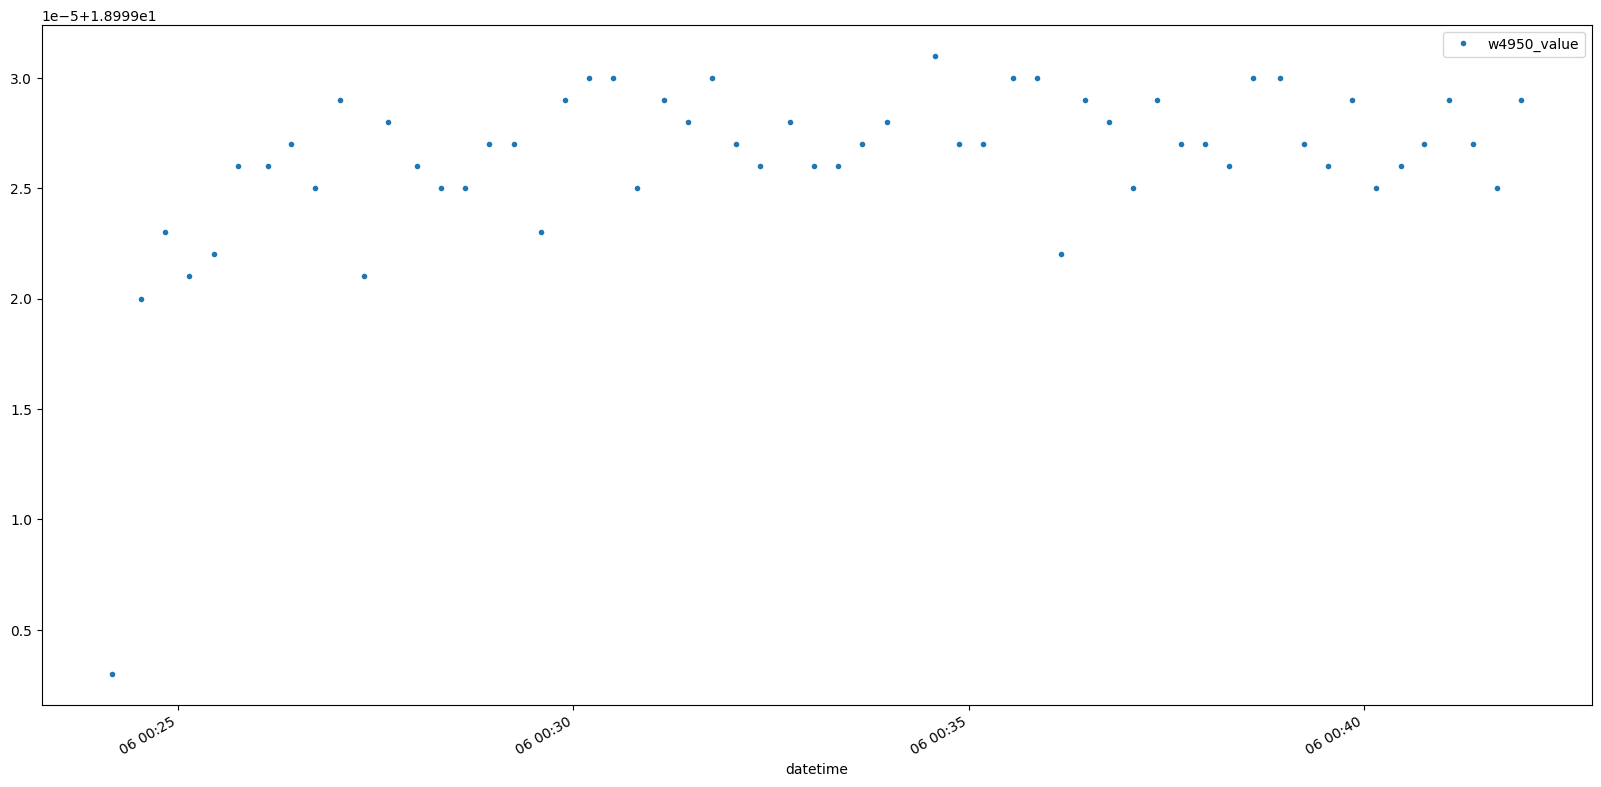

In [75]:
measurement_range = transfer_w4950_cleaned[(transfer_w4950_cleaned.dut == 'D4700+19V') & (transfer_w4950_cleaned.index < pd.Timestamp(2023,11,6,1,0)) & (transfer_w4950_cleaned.w4950_value < 18.9992)]
measurement_range.plot(y='w4950_value', style='.')
measurement_range.w4950_value.describe()

count    3047.000000
mean       18.999366
std         0.000004
min        18.999343
25%        18.999364
50%        18.999366
75%        18.999368
max        18.999378
Name: w4950_value, dtype: float64

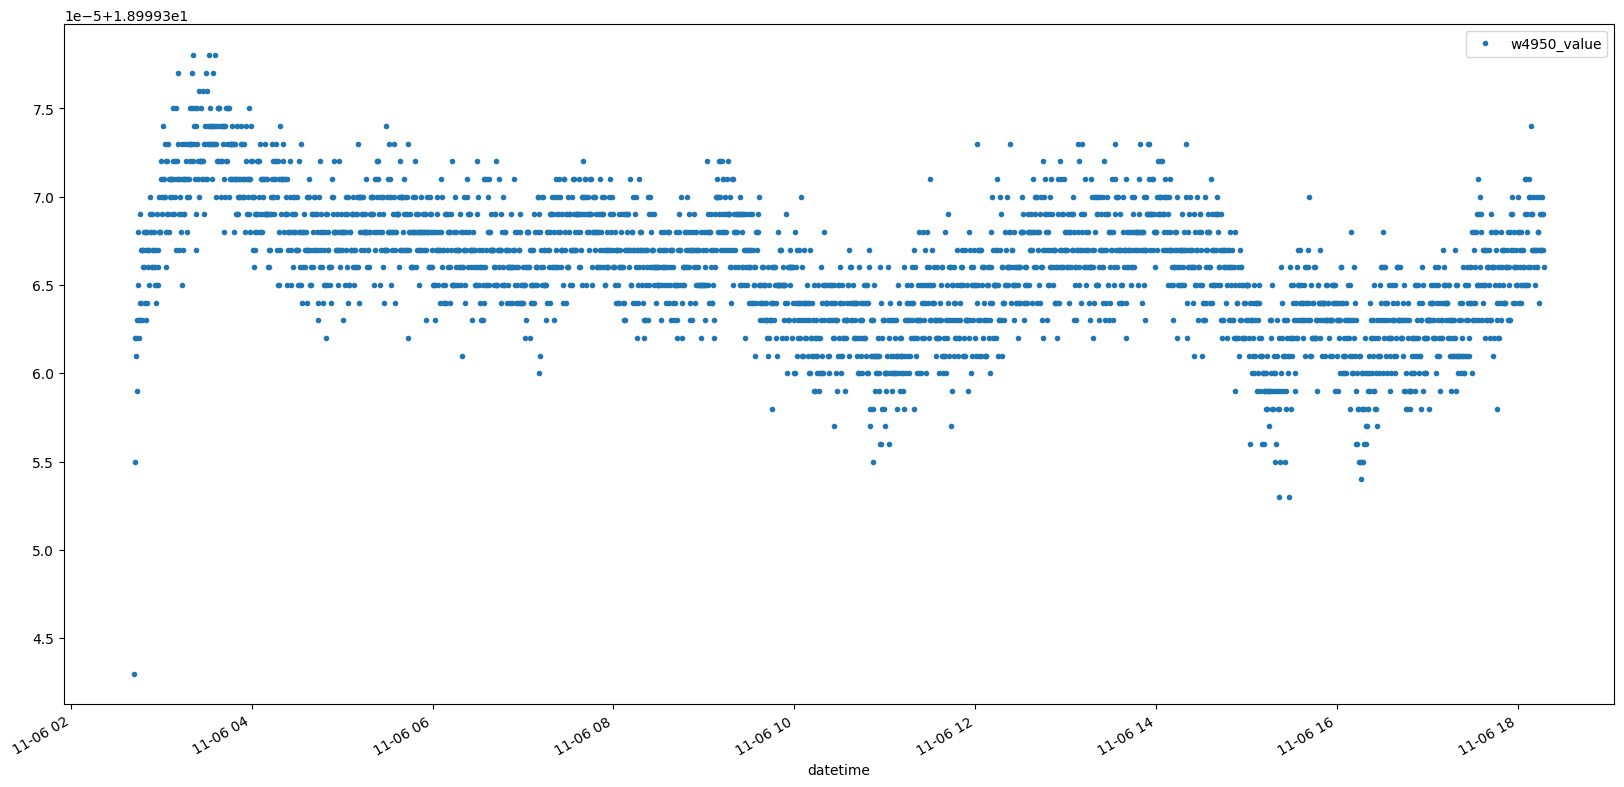

In [76]:
longterm_range = transfer_w4950_cleaned[(transfer_w4950_cleaned.dut == 'D4700+19V') & (transfer_w4950_cleaned.index > pd.Timestamp(2023,11,6,1,0))]
longterm_range.plot(y='w4950_value', style='.')
longterm_range.w4950_value.describe()

count    2298.000000
mean      -18.999359
std         0.000003
min       -18.999369
25%       -18.999360
50%       -18.999359
75%       -18.999357
max       -18.999349
Name: w4950_value, dtype: float64

1.5545999762498708e-07

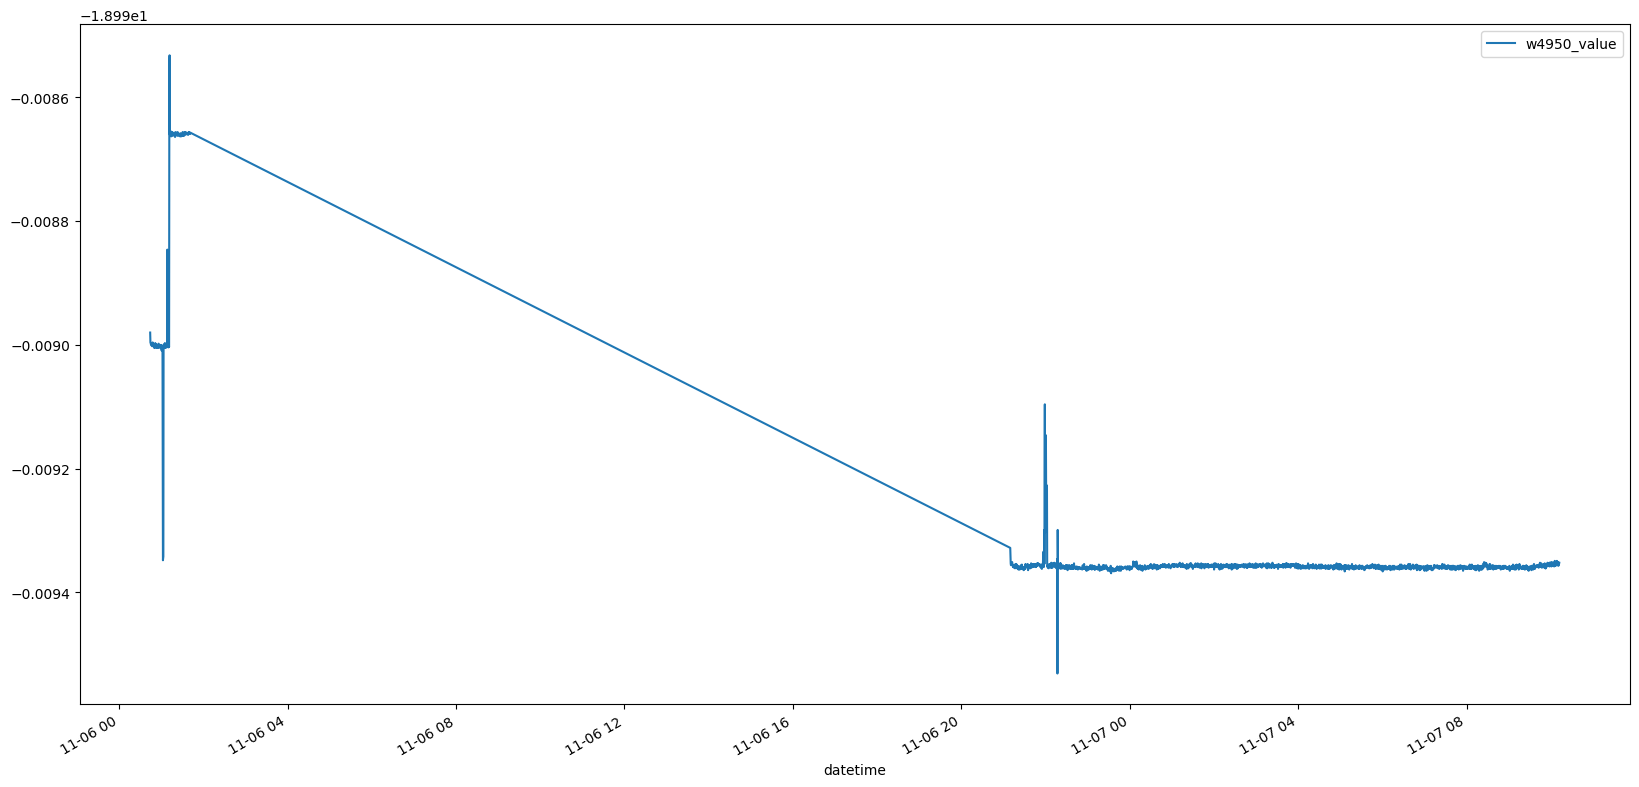

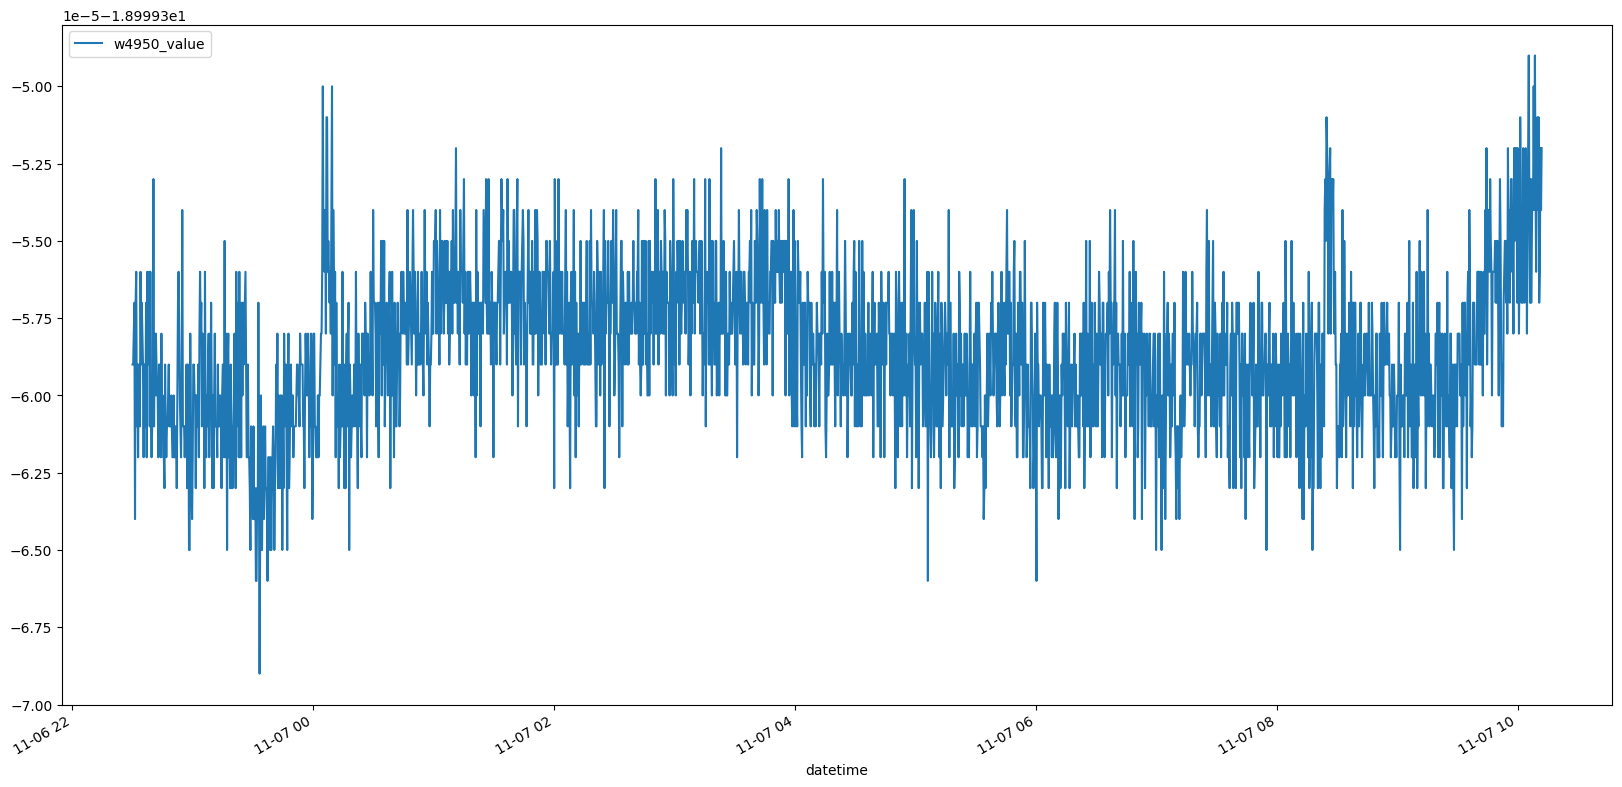

In [105]:
transfer_w4950_neg19V = transfer_w4950_cleaned[transfer_w4950_cleaned.dut == 'D4700-19V'].copy()
transfer_w4950_neg19V = transfer_w4950_neg19V[transfer_w4950_neg19V.w4950_value < -18.9]
transfer_w4950_neg19V.plot(y='w4950_value')
transfer_w4950_neg19V[transfer_w4950_neg19V.index > pd.Timestamp(2023,11,6,22,30)].plot(y='w4950_value')
display(transfer_w4950_neg19V[transfer_w4950_neg19V.index > pd.Timestamp(2023,11,6,22,30)]['w4950_value'].describe())
display(transfer_w4950_neg19V[(transfer_w4950_neg19V.index > pd.Timestamp(2023,11,6,22,30)) & (transfer_w4950_neg19V.index < pd.Timestamp(2023,11,6,23,30))]['w4950_value'].sem())

count    8661.000000
mean      -18.999327
std         0.000025
min       -18.999399
25%       -18.999341
50%       -18.999323
75%       -18.999314
max       -18.999245
Name: ag3458a_1_dcv, dtype: float64

2.635478097285257e-07

count    557.000000
mean     -18.999369
std        0.000009
min      -18.999399
25%      -18.999374
50%      -18.999369
75%      -18.999363
max      -18.999346
Name: ag3458a_1_dcv, dtype: float64

3.6549612854064585e-07

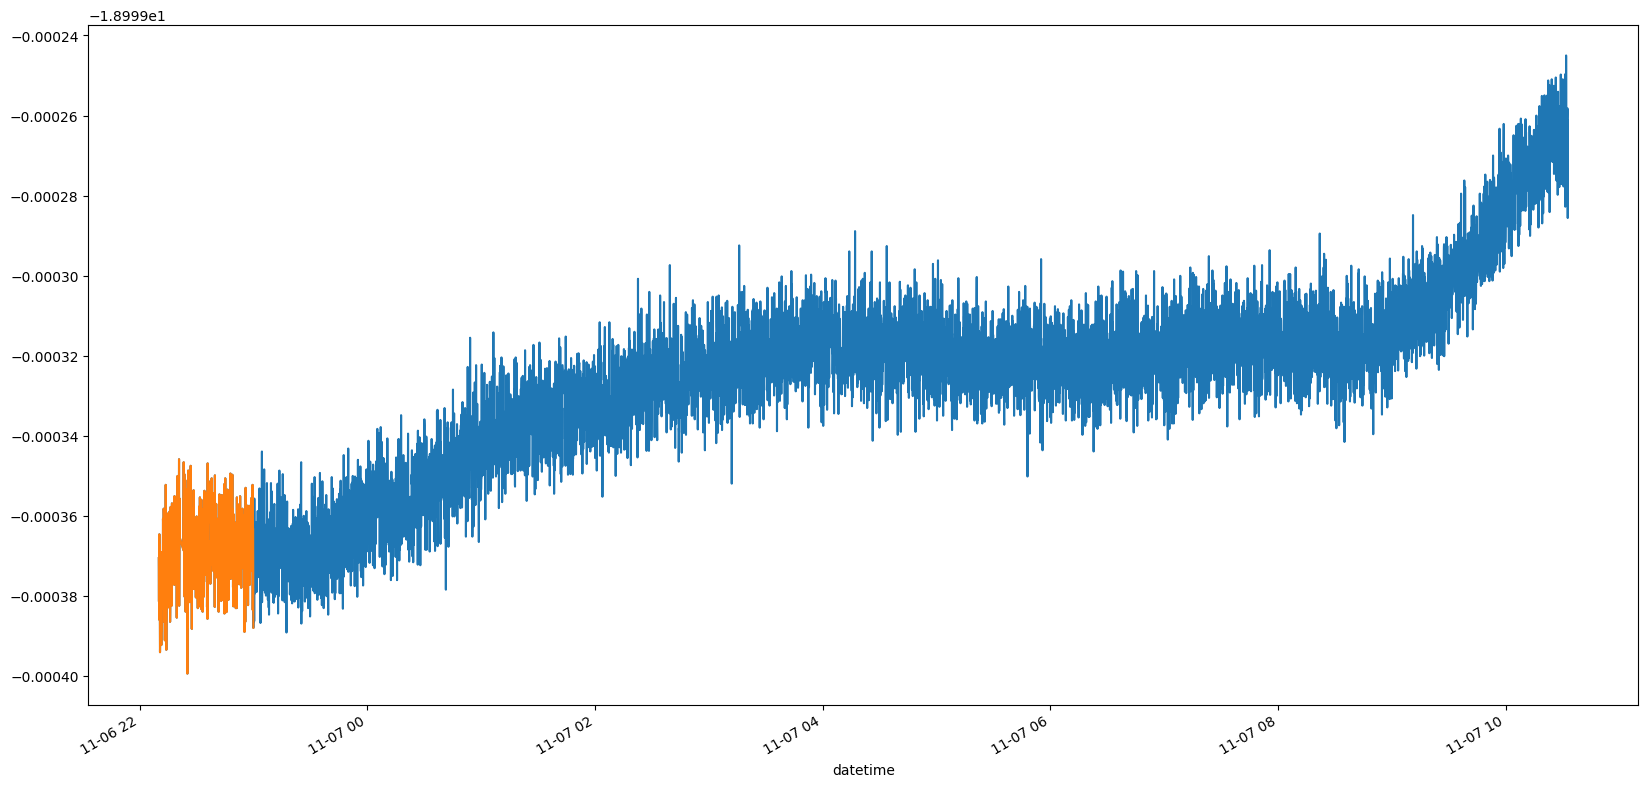

In [103]:
transfer_ks3458a1_dcv_19v.ag3458a_1_dcv.plot()
display(transfer_ks3458a1_dcv_19v.ag3458a_1_dcv.describe())
display(transfer_ks3458a1_dcv_19v.ag3458a_1_dcv.sem())
transfer_ks3458a1_dcv_19v[transfer_ks3458a1_dcv_19v.index < pd.Timestamp(2023,11,6,23,0)].ag3458a_1_dcv.plot()
display(transfer_ks3458a1_dcv_19v[transfer_ks3458a1_dcv_19v.index < pd.Timestamp(2023,11,6,23,0)].ag3458a_1_dcv.describe())
display(transfer_ks3458a1_dcv_19v[transfer_ks3458a1_dcv_19v.index < pd.Timestamp(2023,11,6,23,0)].ag3458a_1_dcv.sem())

In [110]:
transfer_ks3458a1_dcv
data_with_groups = add_dut_and_setting_group(transfer_ks3458a1_dcv)
cleaned_data = aggregate_absolute_data_by_group(
        data_with_groups, 'ag3458a_1', True
    )

In [111]:
cleaned_data

ag3458a_1_dcv                               temperature            \
               mean       std           sem count        mean       std   
group                                                                     
1          9.499259  0.000414  1.004169e-04    17   31.438477  0.005919   
2          9.499446  0.001030  2.303109e-04    20   31.475967  0.005594   
3          9.499348  0.000006  1.471818e-06    17   31.495715  0.005132   
4          9.499677  0.000004  9.882160e-07    16   31.482581  0.009290   
5          9.499359  0.000003  8.410301e-07    17   31.501034  0.005477   
6          9.499677  0.000003  6.780847e-07    16   31.541162  0.010446   
7         -9.499682  0.000003  6.676201e-07    16   31.499731  0.005137   
8         -9.499362  0.000003  7.904303e-07    17   31.512718  0.005240   
9         -9.499681  0.000003  7.352799e-07    16   31.513159  0.002835   
10        -9.499383  0.000087  2.052309e-05    18   31.537435  0.007484   
11        -9.499680  0.000003  7.936263e-07    16   31.559875  0.004470   
12        -9.499362  0.000003  6.599285e-07    18   31.639735  0.018104   
13        -9.499512  0.000754  1.729121e-04    19   31.907926  0.048182   
14        -9.499726  0.000005  1.147906e-06    17   31.989419  0.004708   
15        -9.499325  0.000029  6.572738e-06    20   32.031055  0.002897   

                         pressure                             humidity  \
            sem count        mean       std       sem count       mean   
group                                                                    
1      0.001436    17  991.814356  0.027756  0.006732    17  31.378309   
2      0.001251    20  991.854001  0.035769  0.007998    20  30.969203   
3      0.001245    17  991.933952  0.075510  0.018314    17  30.883447   
4      0.002323    16  992.033461  0.063880  0.015970    16  30.644288   
5      0.001328    17  992.013010  0.060243  0.014611    17  30.424366   
6      0.002612    16  991.948374  0.037335  0.009334    16  30.561212   
7      0.001284    16  992.100963  0.046047  0.011512    16  30.423129   
8      0.001271    17  992.118708  0.019594  0.004752    17  30.261048   
9      0.000709    16  992.143538  0.022997  0.005749    16  30.120669   
10     0.001764    18  992.197758  0.025402  0.005987    18  30.329259   
11     0.001117    16  992.303425  0.033022  0.008256    16  30.135044   
12     0.004267    18  992.213819  0.025178  0.005934    18  30.176291   
13     0.011054    19  992.256449  0.032641  0.007488    19  30.635819   
14     0.001142    17  992.305938  0.027201  0.006597    17  30.328416   
15     0.000648    20  992.356937  0.019578  0.004378    20  30.672399   

                                                                  dut  \
            std       sem count                                  last   
group                                                                   
1      0.172416  0.041817    17   SR104-GL9330-10k-42709-across-SR104   
2      0.073539  0.016444    20  SR104-GL9330-10k-42709-across-GL9330   
3      0.073528  0.017833    17   SR104-GL9330-10k-42709-across-SR104   
4      0.064438  0.016110    16  SR104-GL9330-10k-42709-across-GL9330   
5      0.043682  0.010594    17   SR104-GL9330-10k-42709-across-SR104   
6      0.124164  0.031041    16  SR104-GL9330-10k-42709-across-GL9330   
7      0.052279  0.013070    16  SR104-GL9330-10k-42709-across-GL9330   
8      0.051359  0.012456    17   SR104-GL9330-10k-42709-across-SR104   
9      0.031146  0.007787    16  SR104-GL9330-10k-42709-across-GL9330   
10     0.114723  0.027041    18   SR104-GL9330-10k-42709-across-SR104   
11     0.040977  0.010244    16  SR104-GL9330-10k-42709-across-GL9330   
12     0.064768  0.015266    18   SR104-GL9330-10k-42709-across-SR104   
13     0.186625  0.042815    19   SR104-GL9330-10k-45809-across-SR104   
14     0.054464  0.013209    17  SR104-GL9330-10k-45809-across-GL9330   
15     0.103016  0.023035    20   SR104-GL9330-10k-45809-across-SR104   

      d

In [189]:
with_before_and_after = pd.concat(
        [cleaned_data, cleaned_data.shift(1).add_suffix("_before"), cleaned_data.shift(-1).add_suffix("_after")],
        axis=1,
    )

In [206]:
gl9330_10k_42709 = with_before_and_after[with_before_and_after[('dut', 'last')] == 'SR104-GL9330-10k-42709-across-GL9330'].copy()
gl9330_10k_42709[('voltage_ratio', 'mean')] = gl9330_10k_42709.apply(lambda row: row[('ag3458a_1_dcv', 'mean')] / np.mean([x for x in (row[('ag3458a_1_dcv_before', 'mean_before')], row[('ag3458a_1_dcv_after', 'mean_after')]) if np.sign(x) == np.sign(row[('ag3458a_1_dcv', 'mean')])]), axis=1)

def voltage_ratio_sem(row):
    ref_means = []
    ref_sems = []
    for suffix in ('_before', '_after'):
        if np.sign(row[('ag3458a_1_dcv', 'mean')]) == np.sign(row[('ag3458a_1_dcv' + suffix, 'mean' + suffix)]):
            ref_means.append(row[('ag3458a_1_dcv' + suffix, 'mean' + suffix)])
            ref_sems.append(row[('ag3458a_1_dcv' + suffix, 'sem' + suffix)])
    ref_mean = np.mean(ref_means)
    ref_sem = combine_stds_sum(np.array(ref_sems)) if len(ref_sems) > 1 else ref_sems[0]
    return combine_stds_ratio_product(row[('voltage_ratio', 'mean')], row[('ag3458a_1_dcv', 'mean')], row[('ag3458a_1_dcv', 'sem')], ref_mean, ref_sem)

gl9330_10k_42709[('voltage_ratio', 'sem')] = gl9330_10k_42709.apply(voltage_ratio_sem, axis=1)


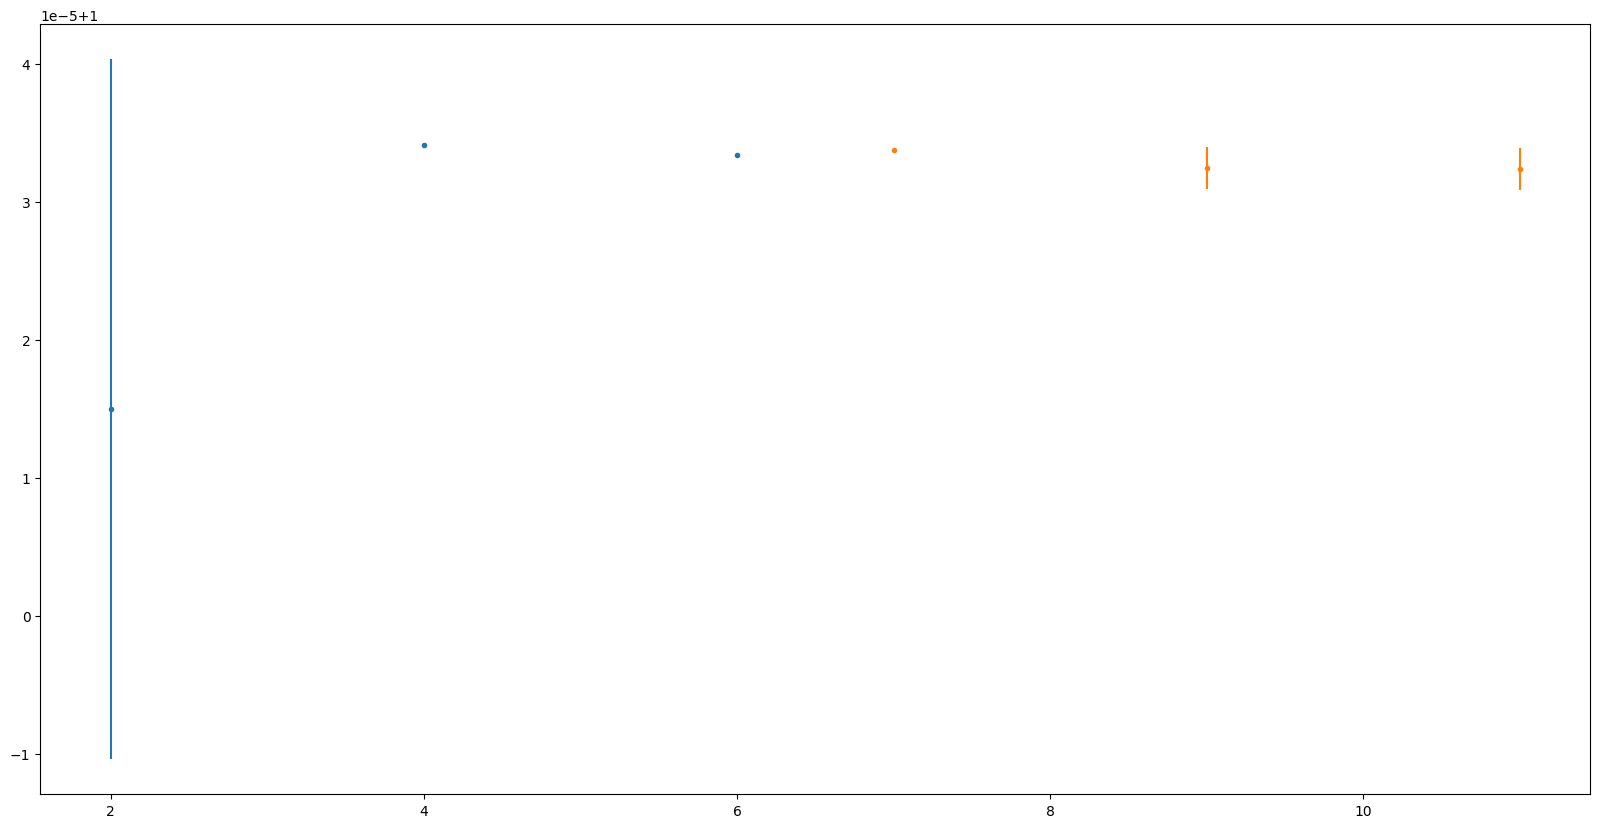

In [215]:
#gl9330_10k_42709.plot(y=('voltage_ratio', 'mean'), yerr=('voltage_ratio', 'sem'), style='.')
# sns.relplot(data=gl9330_10k_42709, y=('voltage_ratio', 'mean'))
for dut_setting in gl9330_10k_42709[('dut_setting', 'last')].unique():
    data = gl9330_10k_42709[gl9330_10k_42709[('dut_setting', 'last')] == dut_setting]
    plt.errorbar(x=data.index, y=data[('voltage_ratio', 'mean')], yerr=data[('voltage_ratio', 'sem')], fmt='.', label=dut_setting)